In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
train = pd.read_csv("train data.csv")
test = pd.read_csv("test data.csv")

In [3]:
print("train shape : {} test shape : {}".format(train.shape, test.shape))

train shape : (199410, 8) test shape : (49414, 6)


In [4]:
train.head(3)

,id,ad,link,timestamp,checkout,order_placed,grp,funnel_level
0,session446676598812,ad412316860435,link1288490188810,2018-04-30T14:39:22.000-04:00,1,1,grp936302870529,lower
1,session60129542152,ad584115552306,link1288490188810,2018-04-30T08:39:23.000-04:00,1,1,grp936302870529,lower
2,session1511828488251,ad1056561954841,link1288490188810,2018-04-30T17:24:01.000-04:00,1,1,grp936302870529,lower


In [5]:
train.isnull().sum()

id                  0
ad              79375
link                0
timestamp           0
checkout            0
order_placed        0
grp                 0
funnel_level        0
dtype: int64

In [6]:
train.describe()

,checkout,order_placed
count,199410.000000,199410.000000
mean,0.416529,0.198155
std,0.492985,0.398610
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199410 entries, 0 to 199409
Data columns (total 8 columns):
id              199410 non-null object
ad              120035 non-null object
link            199410 non-null object
timestamp       199410 non-null object
checkout        199410 non-null int64
order_placed    199410 non-null int64
grp             199410 non-null object
funnel_level    199410 non-null object
dtypes: int64(2), object(6)
memory usage: 12.2+ MB


### Handling missing values

In [8]:
train['ad'].fillna(method = 'ffill', axis  = 0, inplace = True)
test['ad'].fillna(method = 'ffill', axis  = 0, inplace = True)

In [9]:
train.nunique()

id              13977
ad              10362
link             5232
timestamp       62697
checkout            2
order_placed        2
grp               108
funnel_level        3
dtype: int64

In [10]:
train.columns

Index(['id', 'ad', 'link', 'timestamp', 'checkout', 'order_placed', 'grp',
       'funnel_level'],
      dtype='object')

In [11]:
train.dtypes

id              object
ad              object
link            object
timestamp       object
checkout         int64
order_placed     int64
grp             object
funnel_level    object
dtype: object

## Data Visualization

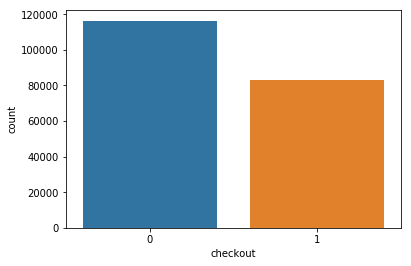

In [12]:
#this will give the estimate of how many users have checkout
sns.countplot(x = 'checkout', data= train)

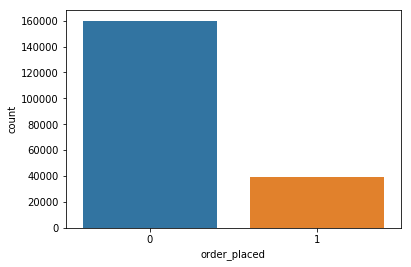

In [13]:
#this will give the estimate of how many of users have placed the order.
sns.countplot(x = 'order_placed', data= train)

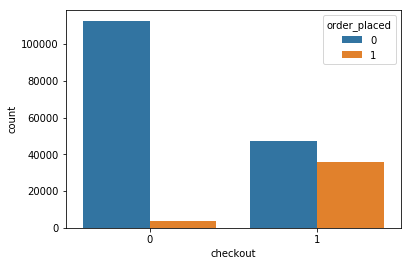

In [14]:
sns.countplot(x = 'checkout', data= train,hue = 'order_placed')

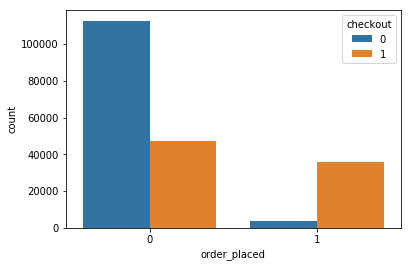

In [15]:
sns.countplot(x = 'order_placed', data= train, hue= 'checkout')

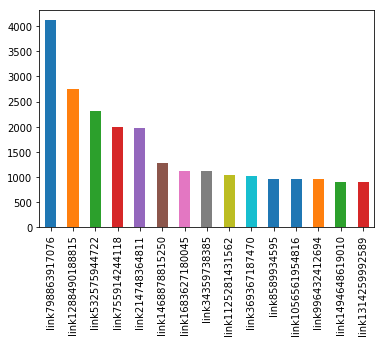

In [17]:
train[train['checkout']==1]['link'].value_counts()[:15].plot(kind='bar')

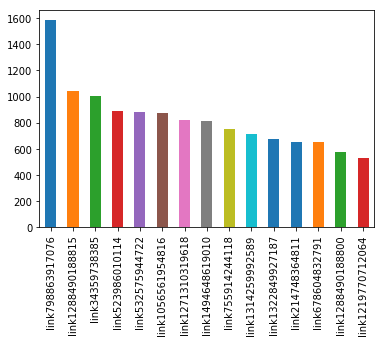

In [18]:
train[train['order_placed']==1]['link'].value_counts()[:15].plot(kind='bar')

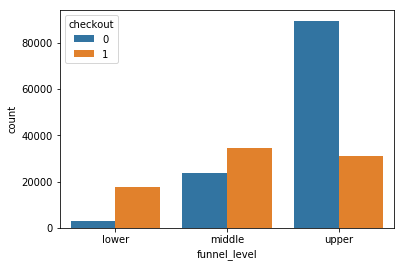

In [19]:
sns.countplot(x = 'funnel_level', data= train, hue='checkout')

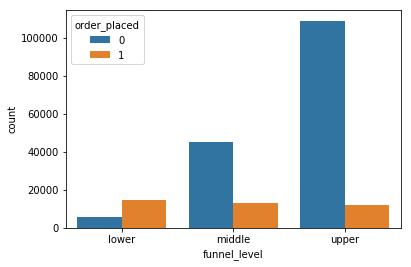

In [20]:
sns.countplot(x = 'funnel_level', data= train, hue='order_placed')

In [12]:
#converting timestamp column to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

### Feature Engineering

In [13]:
#creating feature 'click_hour' from existing feature 'timestamp'.
train['click_hour'] = train['timestamp'].dt.hour
train['click_min'] = train['timestamp'].dt.minute
test['click_hour'] = test['timestamp'].dt.hour
test['click_min'] = test['timestamp'].dt.minute

In [14]:
def session_duration(x) :
    x['session_start'] = x['click_hour'].min()
    x['session_end'] = x['click_hour'].max()
    x['start_min'] = x['click_min'].min()
    x['end_min'] = x['click_min'].max()
    return x
train = train.groupby('id').apply(session_duration)

In [15]:
train['session_duration'] = ((train['session_end'] - train['session_start']) * 60) + (train['end_min']-
train['start_min'] )

In [16]:
def mean_time(x) :
    x['mean_time'] = x['session_duration'].mean()
    x['click_std'] = x['session_duration'].std()
    return x
train = train.groupby('id').apply(mean_time)

In [17]:
def session_duration(x) :
    x['session_start'] = x['click_hour'].min()
    x['session_end'] = x['click_hour'].max()
    x['start_min'] = x['click_min'].min()
    x['end_min'] = x['click_min'].max()
    return x
test = test.groupby('id').apply(session_duration)

In [18]:
test['session_duration'] = ((test['session_end'] - test['session_start']) * 60) + (test['end_min']-
test['start_min'] )   

In [19]:
def mean_time(x) :
    x['mean_time'] = x['session_duration'].mean()
    x['click_std'] = x['session_duration'].std()
    return x
test = test.groupby('id').apply(mean_time)

In [20]:
train['click_std'].fillna(0, axis  = 0, inplace = True)
test['click_std'].fillna(0, axis  = 0, inplace = True)

In [21]:
from pandas import set_option
correlation = train.corr()
set_option('display.width', 100)
set_option('precision', 3)
print (correlation)

                  checkout  order_placed  click_hour  click_min  session_start  session_end  \
checkout             1.000     4.940e-01       0.001  1.056e-02         -0.045        0.055   
order_placed         0.494     1.000e+00       0.008 -1.185e-05         -0.008        0.031   
click_hour           0.001     7.914e-03       1.000  3.288e-02          0.874        0.894   
click_min            0.011    -1.185e-05       0.033  1.000e+00          0.016        0.024   
session_start       -0.045    -7.673e-03       0.874  1.629e-02          1.000        0.772   
session_end          0.055     3.148e-02       0.894  2.418e-02          0.772        1.000   
start_min           -0.241    -2.153e-01      -0.008  5.026e-01          0.082       -0.092   
end_min              0.263     2.076e-01       0.033  5.466e-01         -0.053        0.117   
session_duration     0.171     7.824e-02      -0.018  1.262e-02         -0.383        0.289   
mean_time            0.171     7.824e-02      -0.0

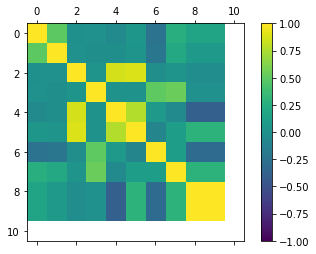

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [23]:
train.drop(['timestamp', 'click_hour'], axis = 1, inplace = True)
test.drop(['timestamp', 'click_hour'], axis = 1, inplace = True)

## Label Encoding

In [24]:
#label encoding of train data
from sklearn.preprocessing import LabelEncoder
cat_var = [i for i in train.columns if train[i].dtypes=='O']
le = LabelEncoder()
for var in cat_var :
   train[var] = le.fit_transform(train[var].astype(str))

In [25]:
#label encoding of test data
from sklearn.preprocessing import LabelEncoder
cat_var = [i for i in test.columns if test[i].dtypes=='O']
le = LabelEncoder()
for var in cat_var :
   test[var] = le.fit_transform(test[var].astype(str))

In [26]:
df_train = train.drop(['order_placed'], axis = 1)

In [27]:
import warnings
warnings.filterwarnings('ignore')

### Splitting train and test data

In [28]:
# Splitting the train_data into the Training set and Test set
X2 = df_train.loc[:, df_train.columns != 'checkout']
Y2 = df_train.loc[:, ['checkout']]
from sklearn.cross_validation import train_test_split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.25, random_state = 0)

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [30]:
categorical_indices= np.where(df_train.dtypes!= np.float)[0]
cb = CatBoostClassifier(iterations =1000, learning_rate=0.01, max_depth = 3, logging_level= 'Silent',
                        random_seed=2018, one_hot_max_size=5)
cb.fit(X_train2, Y_train2, categorical_indices, early_stopping_rounds= 50, verbose= 100)
pred = cb.predict(X_test2)
print('Test Set')
print('CatBoost roc-auc')
accuracy_score(Y_test2, pred)
    

0:	learn: 0.6542797	total: 661ms	remaining: 11m
100:	learn: 0.0426096	total: 30.2s	remaining: 4m 28s
200:	learn: 0.0353647	total: 59s	remaining: 3m 54s
300:	learn: 0.0329731	total: 1m 31s	remaining: 3m 32s
400:	learn: 0.0318706	total: 2m 5s	remaining: 3m 8s
500:	learn: 0.0313986	total: 2m 47s	remaining: 2m 47s
600:	learn: 0.0310613	total: 3m 33s	remaining: 2m 21s
700:	learn: 0.0308167	total: 4m 15s	remaining: 1m 48s
800:	learn: 0.0305910	total: 4m 52s	remaining: 1m 12s
900:	learn: 0.0303792	total: 5m 32s	remaining: 36.5s
999:	learn: 0.0302121	total: 6m 14s	remaining: 0us
Test Set
CatBoost roc-auc


0.9997592923194191

In [31]:
#making prediction for test data
prediction1 = cb.predict(test)
test['checkout'] = prediction1

In [32]:
# Splitting the train_data into the Training set and Test set
X = train.loc[:, train.columns != 'order_placed']
Y = train.loc[:, ['order_placed']]
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [33]:
et1= ExtraTreesClassifier(random_state=0)
et1.fit(X_train, Y_train)
pred1 = et1.predict(X_test)
print('Test Set')
print('extraTrees roc-auc')
roc_auc_score(Y_test, pred1)

Test Set
extraTrees roc-auc


0.9815444272069399

In [34]:
rf1 = RandomForestClassifier(random_state=0)
rf1.fit(X_train, Y_train)
pred1 = rf1.predict(X_test)
print('Test Set')
print('RandomForest roc-auc')
roc_auc_score(Y_test, pred1)

Test Set
RandomForest roc-auc


0.9785254594590859

In [35]:
dt1 = DecisionTreeClassifier(random_state=0)
dt1.fit(X_train, Y_train)
pred1 = dt1.predict(X_test)
print('Test Set')
print('decision tree roc-auc')
roc_auc_score(Y_test, pred1)

Test Set
decision tree roc-auc


0.9715696991060584

In [36]:
lg = LGBMClassifier(objective= 'binary', max_depth =3, min_data_in_leaf = 100, learning_rate= 0.01,
                   bagging_fraction=0.7, feature_fraction =0.8, bagging_freq=5)
lg.fit(X_train, Y_train)
pred1 = lg.predict(X_test)
print('Test Set')
print('LGBMClassifier roc-auc')
roc_auc_score(Y_test, pred1)

Test Set
LGBMClassifier roc-auc


0.6472018679339061

In [37]:
test2 = test.copy()

In [38]:
test3= test.copy()

In [39]:
test4= test.copy()

In [40]:
test5= test.copy()

In [55]:
#making prediction for test data
prediction5 = lg.predict(test5)
test5['order_placed']= prediction5

In [56]:
test_df = pd.read_csv('test data.csv')

In [57]:
#read the submission file
submission = pd.DataFrame({'id' : test_df['id'], 'order_placed' : prediction5})

In [58]:
#now, converting submission file to csv file
submission.to_csv('sollg.csv', index=False)